In [1]:
'''This Notebook generates Figure 3g for the MIST manuscript'''

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import numpy as np
from tqdm.notebook import trange

In [2]:
data_names = ['MouseWT', 'MouseAD', 'Prostate', 'Melanoma']

In [3]:
def corrs(ori, ho, im):
    """This method calculate the SCC and PCC between:
        1. holdout data vs. ground truth
        2. imputed data vs. ground truth
        3. Improvement of MIST through 2 - 1
    """
    ori = ori.loc[ho.index, ho.columns]
    im = im.loc[ho.index, ho.columns]
    dfs = []
    genes = ho.columns.tolist()
    for i in range(len(genes)):
        g = genes[i]
        inds = np.where(ori[g].to_numpy())
        ori_nonzeros = ori[g].to_numpy()[inds]
        ho_nonzeros = ho[g].to_numpy()[inds]
        im_nonzeros = im[g].to_numpy()[inds]
        
        ho_pcc = pearsonr(ho_nonzeros, ori_nonzeros)[0]
        ho_scc = spearmanr(ho_nonzeros, ori_nonzeros)[0]
        
        im_pcc = pearsonr(im_nonzeros, ori_nonzeros)[0]
        im_scc = spearmanr(im_nonzeros, ori_nonzeros)[0]
        
        del_pcc = im_pcc - ho_pcc
        del_scc = im_scc - ho_scc
        df = pd.DataFrame(data=[[ho_pcc, ho_scc, im_pcc, im_scc, del_pcc, del_scc]], 
                          columns=["ho_pcc", "ho_scc", "im_pcc", "im_scc", "del_pcc", "del_scc"])
        dfs.append(df)
    dfs = pd.concat(dfs)
    return dfs

In [6]:
dfs = []
for dn in data_names:
    ori = pd.read_csv('data/%s/norm.csv' %dn, index_col=0)
    ori = np.log2(ori + 1)
    for cv in trange(5):
        ho = pd.read_csv('data/%s/ho_data_%d.csv' %(dn, cv), index_col=0) # get holdout data
        mist_fn = glob('data/%s/MIST_*_%d.csv' %(dn, cv))[0] # get MIST imptued data
        im = pd.read_csv(mist_fn, index_col=0)
        ho = np.log2(ho + 1) # log transform
        im = np.log2(im + 1)
        
        df = corrs(ori, ho, im) # calculate before and after imputation correlation scores
        df['cv'] = cv
        df['data'] = dn
        dfs.append(df)
dfs = pd.concat(dfs)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0.5, 0, 'Improved SCC')

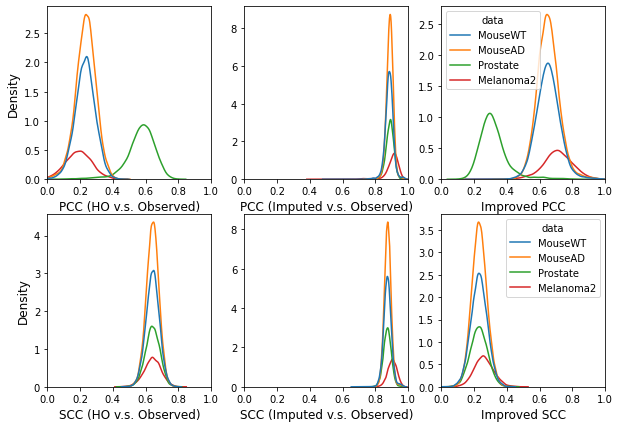

In [72]:
f, axs = plt.subplots(ncols=3, nrows=2, figsize=(10, 7))

sns.kdeplot(data=dfs, x='ho_pcc', hue='data', legend=False,  ax=axs[0,0])
sns.kdeplot(data=dfs, x='im_pcc', hue='data', legend=False, ax=axs[0,1])
sns.kdeplot(data=dfs, x='del_pcc', hue='data',  ax=axs[0,2])
#axs[0,2].legend(bbox_to_anchor=(1.1, 1),borderaxespad=0)

sns.kdeplot(data=dfs, x='ho_scc', hue='data',  legend=False, ax=axs[1,0])
sns.kdeplot(data=dfs, x='im_scc', hue='data', legend=False, ax=axs[1,1])
sns.kdeplot(data=dfs, x='del_scc', hue='data',  ax=axs[1,2])


for i in range(2):
    for j in range(3):
        axs[i,j].set_xlim(0,1)
        if j == 0:
            axs[i,j].set_ylabel("Density", fontsize=12)
        else:
            axs[i,j].set_ylabel("")
        
            
axs[0,0].set_xlabel("PCC (HO v.s. Observed)", fontsize=12)
axs[0,1].set_xlabel("PCC (Imputed v.s. Observed)", fontsize=12)
axs[0,2].set_xlabel("Improved PCC", fontsize=12)

axs[1,0].set_xlabel("SCC (HO v.s. Observed)", fontsize=12)
axs[1,1].set_xlabel("SCC (Imputed v.s. Observed)", fontsize=12)
axs[1,2].set_xlabel("Improved SCC", fontsize=12)

#plt.savefig('Figures/ExtFig3-4.png', bbox_inches="tight", dpi=300)


In [7]:
dfs

,ho_pcc,ho_scc,im_pcc,im_scc,del_pcc,del_scc,cv,data
0,0.337793,0.690823,0.868973,0.828667,0.531180,0.137844,0,MouseWT
0,0.352192,0.718363,0.892079,0.869835,0.539887,0.151472,0,MouseWT
0,0.379123,0.735832,0.878857,0.839166,0.499733,0.103334,0,MouseWT
0,0.210252,0.613493,0.916158,0.902184,0.705906,0.288691,0,MouseWT
0,0.301479,0.669434,0.854218,0.823019,0.552740,0.153585,0,MouseWT
...,...,...,...,...,...,...,...,...
0,0.307264,0.636603,0.953346,0.949141,0.646081,0.312538,4,Melanoma2
0,0.305532,0.682770,0.941533,0.927878,0.636001,0.245108,4,Melanoma2
0,0.306741,0.631059,0.953261,0.951810,0.646520,0.320751,4,Melanoma2
0,0.218721,0.586595,0.950637,0.947701,0.731916,0.361106,4,Melanoma2


In [8]:
df1 = dfs[['ho_scc', 'data']]
df2 = dfs[['im_scc', 'data']]
df1['group'] = 'holdout'
df2['group'] = 'imputed'
df1.columns = ['scc', 'data', 'group']
df2.columns = ['scc', 'data', 'group']
df_new = pd.concat([df1, df2])
df_new

<ipython-input-8-a4a236967cdc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['group'] = 'holdout'
<ipython-input-8-a4a236967cdc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['group'] = 'imputed'


,scc,data,group
0,0.690823,MouseWT,holdout
0,0.718363,MouseWT,holdout
0,0.735832,MouseWT,holdout
0,0.613493,MouseWT,holdout
0,0.669434,MouseWT,holdout
...,...,...,...
0,0.949141,Melanoma2,imputed
0,0.927878,Melanoma2,imputed
0,0.951810,Melanoma2,imputed
0,0.947701,Melanoma2,imputed


[None, None]

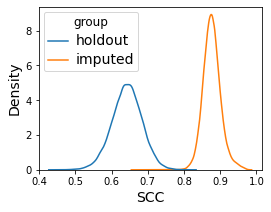

In [31]:
# Figure 3G
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,3))
sns.kdeplot(data=df_new, x="scc", hue='group', color='data', ax=ax)
ax.set_xlabel("SCC", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title

In [34]:
df_new.groupby("group").median()

,scc
group,
holdout,0.642749
imputed,0.875886


In [35]:
from scipy.stats import ttest_rel as pairtest
pairtest(df_new.loc[df_new.group == 'holdout', 'scc'].to_numpy(),
        df_new.loc[df_new.group == 'imputed', 'scc'].to_numpy())

Ttest_relResult(statistic=-1029.124482648959, pvalue=0.0)